# Generalized County Investigation

In order to see what kinds of post-solution analyses would be useful/interesting for the Beta release, this notebook looks at results of finding optimal solutions to the NLP for Lancaster county.

This notebook builds upon the progress made in notebooks 1.0 and 1.1, which looked at Calvert, MD and Lancaster, PA, respectively.  For this notebook, much of the data wrangling has been encapsulated into functions within the 'efficiencysubproblem.src.vis' package.  So, this notebook is another step towards automating the generation of county-scale optimization results' figures.

We will combine the results from both cost-minimization-objective and load-maximization-objective, look at the results' curves, and then plot the results on a map.

### Data Sources
- P6Beta_v3_LRSegs_081516_Albers.shp: a shapefile with land-river-segment geographies throughout the Bay watershed (*Gopal shared this with me via email on 2018/12/11*)
- calvertMD_solutionlist_20181210.txt: a list of optimization solution .csv files to read (*generated these results myself on Cloudfish on 2018/12/10*) 

### Changes
- 2019/01/05: Round 1, start!

### Table of Contents
1. [Load Data](#load_data)
2. [Data Wrangling](#data_wrangling)
3. [Make Graphics](#make_graphics)

In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product

import re

import matplotlib.pyplot as plt
import matplotlib.cm

import geopandas as gpd

In [2]:
from efficiencysubproblem.src.vis import county_investigation as ci

In [3]:
# Specify the county
county_name = 'Calvert'
state_abbrev = 'MD'

<a id='load_data'></a>
# 1. Load Data

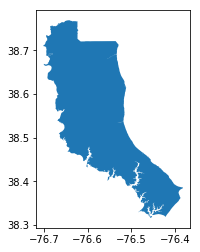

In [4]:
# Shapefiles
lrsegs_geometries_df,\
county_lrsegs_geometries_df,\
whole_county_geometry_df,\
county_bounds = ci.load_shapefiles(county_name=county_name, state_abbrev=state_abbrev)

whole_county_geometry_df.plot()

In [5]:
# Solution data
df,\
df_single_row_for_each_solution = ci.load_solution_data(namelistfile='calvertMD_solutionlist_20181210.txt')
display(df_single_row_for_each_solution.head(2))

,index,Unnamed: 0,acres,bmpshortname,feasible,landriversegment,loadsource,percent_reduction_minimum,solution_objective,solutionname,totalannualizedcostperunit,totalcostupperbound,totalinstancecost,x,objective_cost,objective_loadreduction
0,0,0,43.877017,LowResTill,True,N24009XL0_5346_0000,dbl,1.0,0.000021,solutiondf_modelinstance_costmin_total_percent...,0.0,NaN,0.0,"(LowResTill, N24009XL0_5346_0000, dbl, 0.0)",0.000021,NaN
576,791,3,0.633319,LowResTill,True,N24009WL0_4923_0000,gwm,2.0,0.000142,solutiondf_modelinstance_costmin_total_percent...,0.0,NaN,0.0,"(LowResTill, N24009WL0_4923_0000, gwm, 0.0)",0.000142,NaN


<a id='data_wrangling'></a>
# 2. Data wrangling

In [6]:
# Merge Geodata with Solution data
merged = county_lrsegs_geometries_df.set_index('LndRvrSeg').join(df.set_index('landriversegment'))

In [23]:
# Get total acres implemented for each BMP
bmptotals_pivoted,\
merged_costmin_bmptotals,\
merged_costmin,\
merged_loadredmax = ci.sum_acres_for_bmps(merged=merged)

# Add a column that is the total acres implemented across all BMPS
bmptotals_pivoted['Total'] = bmptotals_pivoted.sum(axis=1)
display(bmptotals_pivoted.head(2))

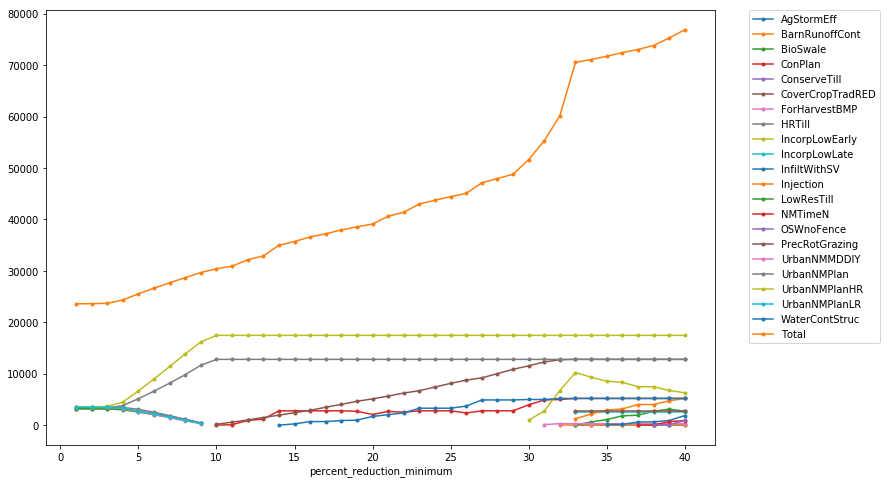

In [25]:
fig, ax = plt.subplots(1, figsize=(12, 8))
bmptotals_pivoted.plot(ax=ax, marker='.')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
"""
coords = {b: hv.Scatter(merged_costmin_bmptotals.loc[merged_costmin_bmptotals['bmpshortname']==b, :],
                    'percent_reduction_minimum', 'acres')
      for b in list(merged_costmin_bmptotals['bmpshortname'])}

hv.HoloMap(coords, kdims='BMP')
"""

In [10]:
# Acres for a particular BMP and for a particular constraint level
constraint_level_selection = 30
bmpselection = 'UrbanNMPlanHR'
thismapdf = ci.county_bmp_gdf(constraint_level_selection, bmpselection,
                           merged_costmin, county_lrsegs_geometries_df).loc[:, ['LndRvrSeg',
                                                                                'acres',
                                                                                'geometry']]

display(thismapdf.head(2))

,LndRvrSeg,acres,geometry
0,N24009XL0_5320_0001,1.049987,POLYGON ((-76.56928950820212 38.60255106129117...
1,N24009XL0_5341_0000,356.634220,POLYGON ((-76.61695006753303 38.52534710568877...


In [12]:
# Convert to geographic data structures
thismapdf, geo_source_json, gsource = ci.mapping(thismapdf)

<a id='make_graphics'></a>
# 3. Make Graphics

In [13]:
from bokeh.plotting import figure
from bokeh.io import output_file, show
import bokeh.models as bkm
from bokeh.transform import linear_cmap

In [14]:
p = figure(title="" + bmpselection + "", match_aspect=True,
           toolbar_location="above",
           background_fill_color='white',
           x_range=(county_bounds['minx'], county_bounds['maxx']), y_range=(county_bounds['miny'], county_bounds['maxy']))
p.grid.visible = False

g1 = bkm.glyphs.Patches(xs='xs', ys='ys', fill_alpha=0.7, 
#           fill_color={'field': 'acres', 'transform': LinearColorMapper(palette=palette)},
          fill_color='grey',
          line_color='black', line_width=0.5)
g1_r = p.add_glyph(source_or_glyph=geo_source_json, glyph=g1)
g1_hover = bkm.HoverTool(renderers=[g1_r],
                         tooltips=[("lrseg", "@LndRvrSeg")])
g1_hover.point_policy = 'follow_mouse'
p.add_tools(g1_hover)

color_mapper = bkm.LinearColorMapper(palette="Viridis256", low=0, high=max(thismapdf['acres']))

g2 = bkm.glyphs.Hex(x="x", y="y",
      fill_color=linear_cmap('acres', 'Viridis256', 0, max(thismapdf['acres'])),
      size=30)
g2_r = p.add_glyph(source_or_glyph=gsource, glyph=g2)
g2_hover = bkm.HoverTool(renderers=[g2_r],
                         tooltips=[("acres implemented", "@acres"), 
                            ("(x,y)", "(@x, @y)"),
                            ("lrseg", "@LndRvrSeg")])
g2_hover.point_policy = 'follow_mouse'
p.add_tools(g2_hover)


color_bar = bkm.ColorBar(color_mapper=color_mapper,
                         label_standoff=12, border_line_color=None, location=(0,0))
p.add_layout(color_bar, 'right')

show(p)